In [4]:
!pip install -q peft transformers bitsandbytes torch torchvision accelerate scikit-learn

import os
import json
import glob
import torch
import torch.nn as nn
import random
import numpy as np
from PIL import Image
from collections import Counter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import SiglipProcessor, SiglipModel, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from torch.optim import AdamW
from tqdm.auto import tqdm

# Setup Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything()

Using device: cuda


In [7]:
# --- Replacement for Cell 2 (Universal Loader) ---
DATASET_ROOT = "/kaggle/input/cctv-more"
MODEL_ID = "google/siglip-so400m-patch14-384"

def load_dataset_metadata(root_dir):
    data_list = []
    
    print(f"Searching for JSONs in {root_dir}...")
    json_files = glob.glob(f"{root_dir}/**/*.json", recursive=True)
    
    if not json_files:
        print("Error: No JSON files found! Check path.")
        return []

    print(f"Found {len(json_files)} JSON files. parsing...")
    
    valid_count = 0
    missing_count = 0
    
    for j_path in json_files:
        try:
            with open(j_path, 'r', encoding='utf-8') as f:
                content = json.load(f)
            
            if isinstance(content, dict):
                entries = [content]
            elif isinstance(content, list):
                entries = content
            else:
                print(f"Unknown format in {os.path.basename(j_path)}")
                continue

            # Loop หาข้อมูลในแต่ละ entry
            for entry in entries:
                # เช็คว่า Key ครบไหม
                if isinstance(entry, dict) and 'filename' in entry and 'json' in entry:
                    img_filename = entry['filename']
                    meta_data = entry['json']
                    parent_dir = os.path.dirname(j_path)
                    img_path = os.path.join(parent_dir, img_filename)
                    
                    # Case-Insensitive
                    if not os.path.exists(img_path):
                        files_in_dir = os.listdir(parent_dir)
                        for f_name in files_in_dir:
                            if f_name.lower() == img_filename.lower():
                                img_path = os.path.join(parent_dir, f_name)
                                break
                    
                    if os.path.exists(img_path):
                        data_list.append({
                            'image_path': img_path,
                            'json': meta_data
                        })
                        valid_count += 1
                    else:
                        missing_count += 1
                        if missing_count <= 3:
                            print(f"❌ Img missing: {img_filename} in {parent_dir}")
                else:
                    if valid_count == 0 and missing_count == 0:
                         print(f"⚠️ Keys mismatch in {os.path.basename(j_path)}: Found keys {list(entry.keys()) if isinstance(entry, dict) else 'Not Dict'}")

        except Exception as e:
            print(f"Error reading {j_path}: {e}")
            
    print(f"Loaded {valid_count} images successfully.")
    print(f"Missing images: {missing_count}")
    
    return data_list

# Load Data
all_data = load_dataset_metadata(DATASET_ROOT)

if len(all_data) == 0:
    raise RuntimeError("Please check the structure!")

# --- Calculate Composite Weights ---
print("Calculating Composite Weights...")
try:
    models = [item['json'].get('car_model', 'unknown') for item in all_data]
    colors = [item['json'].get('primary_color', 'unknown') for item in all_data]
    types = [item['json'].get('car_type', 'unknown') for item in all_data]

    count_model = Counter(models)
    count_color = Counter(colors)
    count_type = Counter(types)

    sample_weights = []
    for m, c, t in zip(models, colors, types):
        w_m = 1.0 / (count_model[m] if count_model[m] > 0 else 1)
        w_c = 1.0 / (count_color[c] if count_color[c] > 0 else 1)
        w_t = 1.0 / (count_type[t] if count_type[t] > 0 else 1)
        sample_weights.append(w_m * w_c * w_t)

    sample_weights = torch.tensor(sample_weights).double()
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    print(f"Sampler ready! Total samples: {len(sample_weights)}")
except Exception as e:
    print(f"⚠️ Error creating sampler: {e}")
    # Fallback to simple sampler if fails
    sampler = None

Searching for JSONs in /kaggle/input/cctv-more...
Found 8 JSON files. parsing...
✅ Loaded 800 images successfully.
❌ Missing images: 0
Calculating Composite Weights...
Sampler ready! Total samples: 800


In [8]:
import pandas as pd

if len(all_data) > 0:
    flat_data = []
    for item in all_data:
        entry = item['json'].copy() 
        entry['image_path'] = item['image_path'] 
        flat_data.append(entry)

    df = pd.DataFrame(flat_data)
    cols = ['filename', 'car_brand', 'car_model', 'primary_color', 'car_type', 'image_path']
    existing_cols = [c for c in cols if c in df.columns] + [c for c in df.columns if c not in cols]
    df = df[existing_cols]

    print(f"Total Rows: {len(df)}")
    print("\n--- 5 Examples ---")
    display(df.head())

    print("\n--- Random 5 rows ---")
    display(df.sample(5))

    # 4. เช็ค Imbalance (สำคัญมากสำหรับเคสของคุณ)
    print("\n---Stats: Top 5 Car Models ---")
    print(df['car_model'].value_counts().head(5))

    print("\n--- Stats: Top 5 Colors ---")
    print(df['primary_color'].value_counts().head(5))
    
    print("\n--- Stats: Car Types ---")
    print(df['car_type'].value_counts())

else:
    print("Doesn't have data")

✅ Total Rows: 800

--- 🔍 ตัวอย่างข้อมูล 5 แถวแรก ---


car_brand car_model primary_color   car_type  \
0    Toyota   Corolla         white      sedan   
1     Honda     Civic         white      sedan   
2    Toyota     Camry         white      sedan   
3    Toyota   Corolla         green      sedan   
4    Toyota     Yaris         white  hatchback   

                                          image_path secondary_color  \
0  /kaggle/input/cctv-more/DatasetCCTV(1)/set5/00...                   
1  /kaggle/input/cctv-more/DatasetCCTV(1)/set5/00...           black   
2  /kaggle/input/cctv-more/DatasetCCTV(1)/set5/00...                   
3  /kaggle/input/cctv-more/DatasetCCTV(1)/set5/00...          yellow   
4  /kaggle/input/cctv-more/DatasetCCTV(1)/set5/00...                   

  wheel_color other_car_marks  num_of_drivers driver_shirt_color  \
0       black                               1            [black]   
1       black            none               1          [unknown]   
2       black                               1                 []   
3       black            taxi               1            [black]   
4       black                               1                 []   

  other_driver_marks  
0                     
1            unknown  
2                     
3      driver inside  
4


--- 🎲 สุ่มดูข้อมูล 5 แถว (เช็คความหลากหลาย) ---


car_brand car_model primary_color      car_type  \
696       Isuzu      MU-X         white           SUV   
667  Mitsubishi    Triton         white  pickup truck   
63           MG        ZS         white           SUV   
533      Toyota     Hilux         white  pickup truck   
66        Honda      City          gray         sedan   

                                            image_path secondary_color  \
696  /kaggle/input/cctv-more/DatasetCCTV(2-3)/Datas...          silver   
667  /kaggle/input/cctv-more/DatasetCCTV(2-3)/Datas...                   
63   /kaggle/input/cctv-more/DatasetCCTV(1)/set5/06...           black   
533  /kaggle/input/cctv-more/DatasetCCTV(1)/set6/03...           black   
66   /kaggle/input/cctv-more/DatasetCCTV(1)/set5/06...                   

    wheel_color other_car_marks  num_of_drivers driver_shirt_color  \
696      silver            none               1                 []   
667       black                               1                 []   
63        black     chrome trim               1            [black]   
533       black            none               1            [black]   
66        black                               1                 []   

    other_driver_marks  
696               none  
667                     
63                none  
533               none  
66


--- 📊 Stats: Top 5 Car Models ---
car_model
Corolla    68
D-Max      59
Hilux      51
Wave       43
Yaris      39
Name: count, dtype: int64

--- 🎨 Stats: Top 5 Colors ---
primary_color
white     428
silver    138
black      92
gray       36
red        35
Name: count, dtype: int64

--- 🚕 Stats: Car Types ---
car_type
sedan           264
SUV             144
pickup truck    131
motorcycle      115
hatchback        78
van              36
minivan          11
scooter           6
songtaew          5
bus               4
sports car        3
truck             2
mini truck        1
Name: count, dtype: int64


In [9]:
class ProductionCarDataset(Dataset):
    def __init__(self, metadata_list):
        self.metadata = metadata_list

    def __len__(self):
        return len(self.metadata)

    def generate_caption(self, item):
        json_data = item['json']
        brand = json_data.get('car_brand', 'Unknown')
        model = json_data.get('car_model', 'Unknown')
        color = json_data.get('primary_color', 'Unknown')
        ctype = json_data.get('car_type', 'vehicle')
        
        # --- Problem #2 Fix: Explicit Template Groups ---
        
        # Group A: Color Isolation (Force Color Attention)
        color_templates = [
            f"The car color is {color}",
            f"This vehicle is {color}",
            f"A {color} colored car",
            f"Paint color: {color}"
        ]
        
        # Group B: Structure/Type Isolation (Force Shape Attention)
        structure_templates = [
            f"A photo of {brand} {model}",
            f"{brand} {model} car",
            f"This is a {ctype}",
            f"A {ctype} on the road"
        ]
        
        # Group C: Full Context (Binding)
        full_templates = [
            f"A {color} {brand} {model} {ctype}",
            f"{color} {brand} {model}",
            f"A {color} taxi" if 'taxi' in str(ctype).lower() else f"A {color} vehicle"
        ]
        
        # Probability Distribution
        rand = random.random()
        if rand < 0.4: # 40% Color Only
            return random.choice(color_templates)
        elif rand < 0.7: # 30% Structure Only
            return random.choice(structure_templates)
        else: # 30% Full Context
            return random.choice(full_templates)

    def __getitem__(self, idx):
        item = self.metadata[idx]
        try:
            image = Image.open(item['image_path']).convert("RGB")
        except:
            image = Image.new('RGB', (384, 384), color='black')
            
        caption = self.generate_caption(item)
        return image, caption

In [15]:
# --- Replacement for Cell 4 (Hybrid Fix) ---
import types

# 1. Config 4-bit Quantization (พร้อมข้อยกเว้น)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    llm_int8_skip_modules=["vision_model.head", "text_model.head"] 
)

# 2. Load Model
processor = SiglipProcessor.from_pretrained(MODEL_ID)
model = SiglipModel.from_pretrained(
    MODEL_ID, 
    quantization_config=bnb_config,
    device_map="auto" 
)

# =========================================================
# 1: SigLIP Embedding Patch
# =========================================================
def get_input_embeddings_patch(self):
    return self.vision_model.embeddings.patch_embedding

model.get_input_embeddings = types.MethodType(get_input_embeddings_patch, model)
# =========================================================

# 3. Prepare for k-bit training
model = prepare_model_for_kbit_training(model)

# 4. LoRA Config (Hybrid Strategy)
peft_config = LoraConfig(
    r=8,        
    lora_alpha=16, 
    
    target_modules=[
        "q_proj", "v_proj", "k_proj", "out_proj", 
        "fc1", "fc2"
    ],
    modules_to_save=["vision_model.head", "text_model.head"],
    
    lora_dropout=0.05,
    bias="none",
)

# Apply LoRA
model = get_peft_model(model, peft_config)

# Debug: Print Trainable Parameters
model.print_trainable_parameters()

# Verify Dtypes
print(f"Vision Head Type: {model.base_model.model.vision_model.head.attention.out_proj.weight.dtype}")

print("Model prepared with Hybrid Strategy (4-bit Backbone + FP16 Head)!")

trainable params: 25,261,904 || all params: 903,222,402 || trainable%: 2.7969
Vision Head Type: torch.float32
✅ Model prepared with Hybrid Strategy (4-bit Backbone + FP16 Head)!


In [16]:
BATCH_SIZE = 16 
EPOCHS = 10 # 800 images, 10-15 epochs is enough with r=8
LR = 1e-4   # Slightly lower LR for r=8

train_dataset = ProductionCarDataset(all_data)
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=sampler, # Composite Sampler
    num_workers=2,
    drop_last=True,
    collate_fn=lambda x: x 
)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

model.train()
print("Start Production-Grade Training...")

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for batch in progress_bar:
        batch_images, batch_texts = zip(*batch)
        
        inputs = processor(
            text=list(batch_texts), 
            images=list(batch_images), 
            padding="max_length", 
            truncation=True, 
            return_tensors="pt"
        ).to(device)
        
        optimizer.zero_grad()
        
        outputs = model(**inputs)
        logits = outputs.logits_per_image
        
        # Diagonal = 1 (Match), Others = 0
        labels = torch.eye(BATCH_SIZE, device=device)
        
        loss = loss_fn(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
        
    print(f"Epoch {epoch+1} Avg Loss: {epoch_loss / len(train_loader):.4f}")

# Save
model.save_pretrained("siglip-production-r8")
processor.save_pretrained("siglip-production-r8")
print("Training Complete. Adapter Saved.")

Start Production-Grade Training...


Epoch 1/10:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1 Avg Loss: 0.3641


Epoch 2/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2 Avg Loss: 0.1753


Epoch 3/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3 Avg Loss: 0.1820


Epoch 4/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4 Avg Loss: 0.1883


Epoch 5/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5 Avg Loss: 0.1662


Epoch 6/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6 Avg Loss: 0.1592


Epoch 7/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7 Avg Loss: 0.1604


Epoch 8/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8 Avg Loss: 0.1618


Epoch 9/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9 Avg Loss: 0.1626


Epoch 10/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10 Avg Loss: 0.1544
Training Complete. Adapter Saved.


Process Process-37:
Process Process-41:
Process Process-38:
Process Process-42:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.12/multiprocessing/util.py", line 363, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.12/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.12/multiprocessing/util.py", line 363, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.12/multiprocessing/util.py", line 363, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.12/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.12/multiprocess

In [18]:
!cd /kaggle/working

!echo "Zipping siglip-vehicle-cctv..."

!zip -r siglip-production-r8.zip siglip-production-r8

!ls -lh siglip-production-r8.zip

Zipping siglip-vehicle-cctv...
  adding: siglip-production-r8/ (stored 0%)
  adding: siglip-production-r8/adapter_config.json (deflated 57%)
  adding: siglip-production-r8/tokenizer_config.json (deflated 63%)
  adding: siglip-production-r8/special_tokens_map.json (deflated 72%)
  adding: siglip-production-r8/README.md (deflated 66%)
  adding: siglip-production-r8/preprocessor_config.json (deflated 50%)
  adding: siglip-production-r8/adapter_model.safetensors (deflated 15%)
  adding: siglip-production-r8/spiece.model (deflated 49%)
-rw-r--r-- 1 root root 83M Feb  3 09:05 siglip-production-r8.zip


In [17]:
# Function to calculate similarity
def predict(image_path, queries):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    
    inputs = processor(
        text=queries, 
        images=image, 
        padding="max_length", 
        truncation=True, 
        return_tensors="pt"
    ).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        # Sigmoid prob for SigLIP
        probs = torch.sigmoid(outputs.logits_per_image) 
    
    print(f"\nImage: {os.path.basename(image_path)}")
    for query, prob in zip(queries, probs[0]):
        print(f"Query: '{query}' \t-> Score: {prob:.4f}")

# --- Test Case ---
if len(all_data) > 0:
    test_item = random.choice(all_data)
    test_img_path = test_item['image_path']
    actual_json = test_item['json']
    
    test_queries = [
        f"A {actual_json.get('primary_color')} {actual_json.get('car_brand')} {actual_json.get('car_model')}", # ถูกต้อง 100%
        f"A red ferrari", # ผิดทั้งสีทั้งรุ่น
        f"A {actual_json.get('primary_color')} taxi", # ถูกสี
        f"A blue {actual_json.get('car_model')}" # ถูกรุ่น ผิดสี
    ]
    
    predict(test_img_path, test_queries)


Image: 055.jpg
Query: 'A red Honda Wave' 	-> Score: 0.8791
Query: 'A red ferrari' 	-> Score: 0.0281
Query: 'A red taxi' 	-> Score: 0.1258
Query: 'A blue Wave' 	-> Score: 0.0000


In [21]:
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 19.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 22.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [23]:
import torch
import os
import json
import chromadb
from PIL import Image
from tqdm import tqdm
from peft import PeftModel
from transformers import AutoProcessor, SiglipModel

# 1. SETUP & MODEL LOADING
# Point this to your "siglip-production-r8" folder path
model_path = "./siglip-production-r8" 
base_model_name = "google/siglip-so400m-patch14-384" # The likely base model

print("Loading fine-tuned model...")
processor = AutoProcessor.from_pretrained(model_path)
base_model = SiglipModel.from_pretrained(base_model_name)
# Load your LoRA weights
model = PeftModel.from_pretrained(base_model, model_path).to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Initialize Vector DB
chroma_client = chromadb.PersistentClient(path="./car_search_db")
collection = chroma_client.get_or_create_collection(
    name="car_inventory", 
    metadata={"hnsw:space": "cosine"}
)

# 2. BATCH INDEXING FUNCTION
def build_index(all_data, batch_size=16):
    print(f"Indexing {len(all_data)} items...")
    
    for i in range(0, len(all_data), batch_size):
        batch = all_data[i : i + batch_size]
        images = []
        metadatas = []
        ids = []

        for item in batch:
            try:
                img = Image.open(item['image_path']).convert("RGB")
                images.append(img)
                # Store original JSON as a string for the payload
                metadatas.append({
                    "image_path": item['image_path'],
                    "groundtruth": json.dumps(item['json']) 
                })
                ids.append(os.path.basename(item['image_path']) + f"_{i}")
            except Exception as e:
                print(f"Error loading {item['image_path']}: {e}")

        if not images: continue

        # Process Batch
        inputs = processor(images=images, return_tensors="pt", padding=True).to(model.device)
        
        with torch.no_grad():
            # Extract image features using the fine-tuned adapter
            img_embs = model.get_image_features(**inputs)
            img_embs = img_embs / img_embs.norm(p=2, dim=-1, keepdim=True)
            embeddings = img_embs.cpu().numpy().tolist()

        # Add to ChromaDB
        collection.add(ids=ids, embeddings=embeddings, metadatas=metadatas)
        print(f"Indexed batch {i//batch_size + 1}")

# 3, 4, & 5. SEARCH FUNCTION
def search(query_text, top_k=1):
    # Embed the user's text query
    inputs = processor(text=[query_text], padding="max_length", return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        text_emb = model.get_text_features(**inputs)
        text_emb = text_emb / text_emb.norm(p=2, dim=-1, keepdim=True)
        query_vector = text_emb.cpu().numpy().tolist()

    # Query DB (Strictly searching by image vectors)
    results = collection.query(query_embeddings=query_vector, n_results=top_k)

    # Output formatting
    for i in range(len(results['ids'][0])):
        meta = results['metadatas'][0][i]
        dist = results['distances'][0][i]
        confidence = 1 - dist # Cosine similarity score
        
        print(f"\n--- Rank {i+1} ---")
        print(f"Confidence: {confidence:.4f}")
        print(f"Image Path: {meta['image_path']}")
        print(f"Groundtruth: {meta['groundtruth']}")


Loading fine-tuned model...


In [24]:
build_index(all_data) # Run this once to populate your DB

Indexing 800 items...
Indexed batch 1
Indexed batch 2
Indexed batch 3
Indexed batch 4
Indexed batch 5
Indexed batch 6
Indexed batch 7
Indexed batch 8
Indexed batch 9
Indexed batch 10
Indexed batch 11
Indexed batch 12
Indexed batch 13
Indexed batch 14
Indexed batch 15
Indexed batch 16
Indexed batch 17
Indexed batch 18
Indexed batch 19
Indexed batch 20
Indexed batch 21
Indexed batch 22
Indexed batch 23
Indexed batch 24
Indexed batch 25
Indexed batch 26
Indexed batch 27
Indexed batch 28
Indexed batch 29
Indexed batch 30
Indexed batch 31
Indexed batch 32
Indexed batch 33
Indexed batch 34
Indexed batch 35
Indexed batch 36
Indexed batch 37
Indexed batch 38
Indexed batch 39
Indexed batch 40
Indexed batch 41
Indexed batch 42
Indexed batch 43
Indexed batch 44
Indexed batch 45
Indexed batch 46
Indexed batch 47
Indexed batch 48
Indexed batch 49
Indexed batch 50


In [25]:
search("A red taxi")


--- Rank 1 ---
Confidence: 0.1412
Image Path: /kaggle/input/cctv-more/DatasetCCTV(2-3)/DatasetCCTV(2-3)/set2/089.jpg
Groundtruth: {"car_type": "sedan", "car_brand": "Toyota", "car_model": "Corolla", "primary_color": "red", "secondary_color": "", "wheel_color": "silver", "other_car_marks": "", "num_of_drivers": 1, "driver_shirt_color": ["blue"], "other_driver_marks": ""}



--- Rank 1 ---
Confidence: 0.1412
Image Path: /kaggle/input/cctv-more/DatasetCCTV(2-3)/DatasetCCTV(2-3)/set2/089.jpg
Groundtruth: {"car_type": "sedan", "car_brand": "Toyota", "car_model": "Corolla", "primary_color": "red", "secondary_color": "", "wheel_color": "silver", "other_car_marks": "", "num_of_drivers": 1, "driver_shirt_color": ["blue"], "other_driver_marks": ""}
Query: 'A red taxi'
Rank 1: /kaggle/input/cctv-more/DatasetCCTV(2-3)/DatasetCCTV(2-3)/set2/089.jpg (Confidence: 0.1412)
Rank 2: /kaggle/input/cctv-more/DatasetCCTV(1)/set8/027.jpg (Confidence: 0.1349)
Rank 3: /kaggle/input/cctv-more/DatasetCCTV(1)/set10/028.jpg (Confidence: 0.1312)


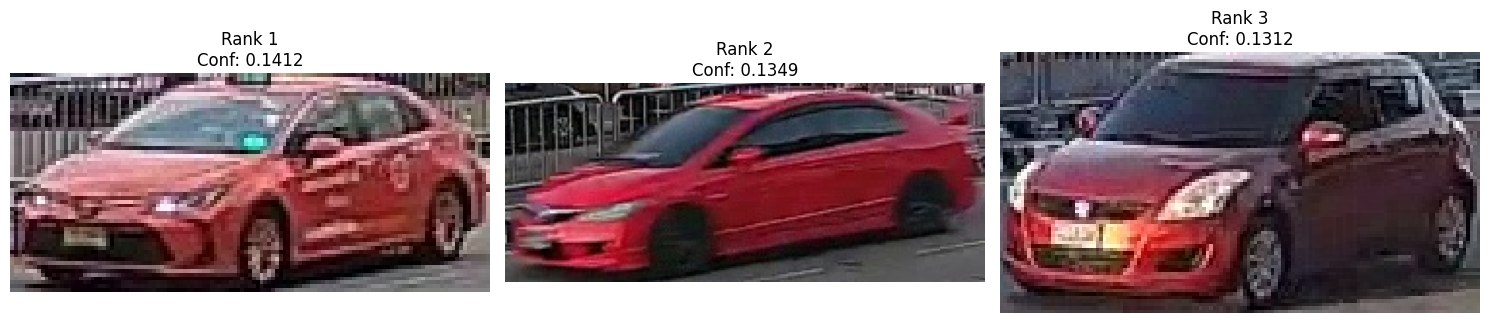

In [29]:
import matplotlib.pyplot as plt
from PIL import Image

def search_and_display(query_text, top_k=3):
    search(query_text)
    inputs = processor(text=[query_text], padding="max_length", return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        text_emb = model.get_text_features(**inputs)
        text_emb = text_emb / text_emb.norm(p=2, dim=-1, keepdim=True)
        query_vector = text_emb.cpu().numpy().tolist()

    results = collection.query(query_embeddings=query_vector, n_results=top_k)

    num_results = len(results['ids'][0])
    plt.figure(figsize=(15, 5)) # ปรับขนาดภาพตามจำนวน top_k
    
    print(f"Query: '{query_text}'")
    
    for i in range(num_results):
        meta = results['metadatas'][0][i]
        dist = results['distances'][0][i]
        confidence = 1 - dist
        img_path = meta['image_path']
        
        try:
            img = Image.open(img_path).convert("RGB")
            
            # สร้าง Subplot
            plt.subplot(1, num_results, i + 1)
            plt.imshow(img)
            plt.title(f"Rank {i+1}\nConf: {confidence:.4f}")
            plt.axis('off')
            
            print(f"Rank {i+1}: {img_path} (Confidence: {confidence:.4f})")
        except Exception as e:
            print(f"Could not load image {img_path}: {e}")

    plt.tight_layout()
    plt.show()

search_and_display("A red taxi", top_k=3)


--- Rank 1 ---
Confidence: 0.1415
Image Path: /kaggle/input/cctv-more/DatasetCCTV(1)/set10/030.jpg
Groundtruth: {"car_type": "sedan", "car_brand": "Toyota", "car_model": "Corolla", "primary_color": "yellow", "secondary_color": "black", "wheel_color": "black", "other_car_marks": "taxi sign on roof", "num_of_drivers": 1, "driver_shirt_color": ["white"], "other_driver_marks": "driver visible through window"}
Query: 'A taxi'
Rank 1: /kaggle/input/cctv-more/DatasetCCTV(1)/set10/030.jpg (Confidence: 0.1415)
Rank 2: /kaggle/input/cctv-more/DatasetCCTV(1)/set5/030.jpg (Confidence: 0.1413)
Rank 3: /kaggle/input/cctv-more/DatasetCCTV(1)/set6/093.jpg (Confidence: 0.1409)


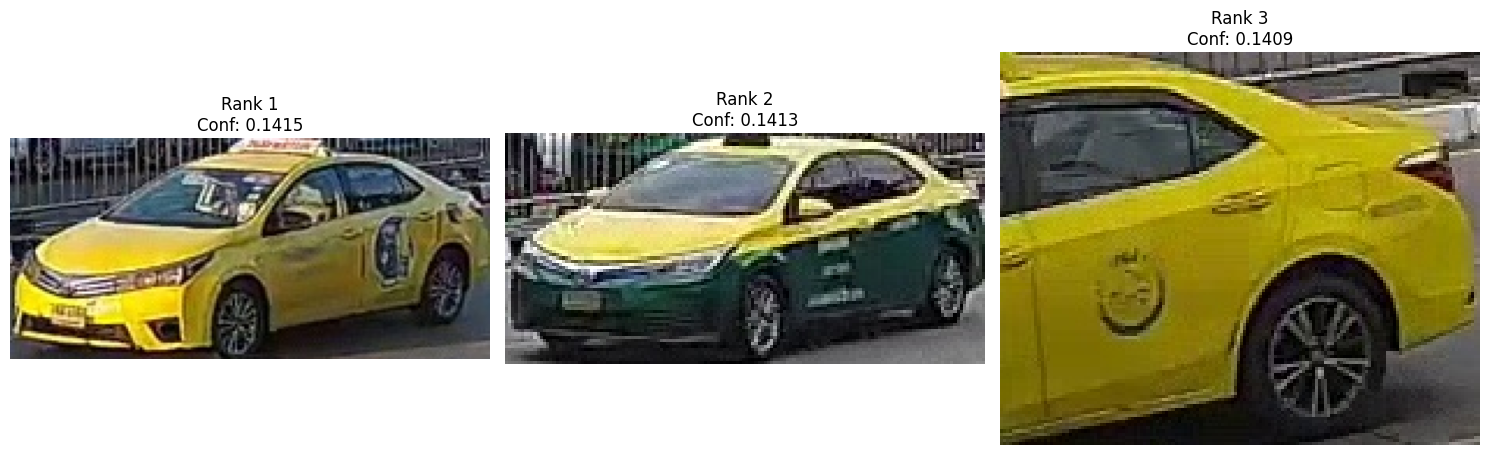

In [30]:
search_and_display("A taxi", top_k=3)


--- Rank 1 ---
Confidence: 0.1443
Image Path: /kaggle/input/cctv-more/DatasetCCTV(1)/set10/034.jpg
Groundtruth: {"car_type": "sedan", "car_brand": "Toyota", "car_model": "vios", "primary_color": "silver", "secondary_color": "", "wheel_color": "black", "other_car_marks": "", "num_of_drivers": 1, "driver_shirt_color": [], "other_driver_marks": ""}
Query: 'A toyota'
Rank 1: /kaggle/input/cctv-more/DatasetCCTV(1)/set10/034.jpg (Confidence: 0.1443)
Rank 2: /kaggle/input/cctv-more/DatasetCCTV(1)/set5/015.jpg (Confidence: 0.1442)
Rank 3: /kaggle/input/cctv-more/DatasetCCTV(1)/set10/047.jpg (Confidence: 0.1439)


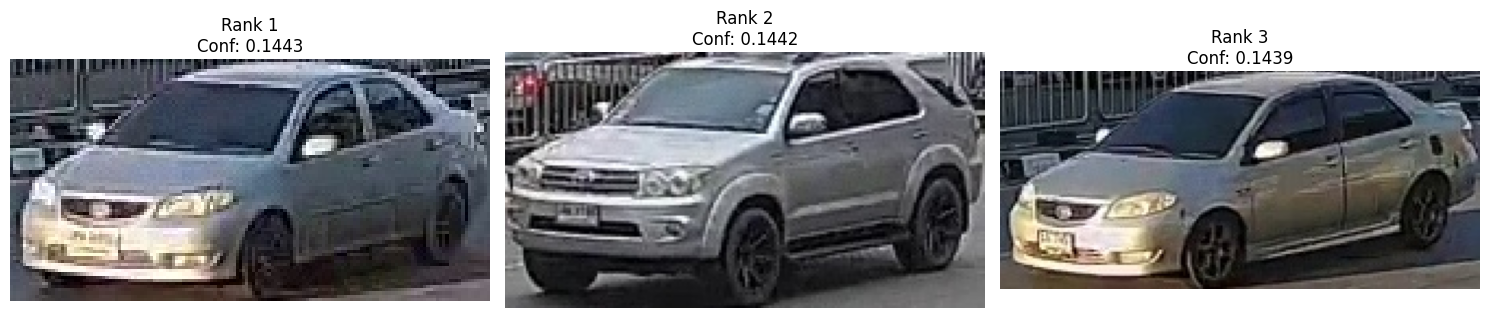

In [31]:
search_and_display("A toyota", top_k=3)


--- Rank 1 ---
Confidence: 0.1674
Image Path: /kaggle/input/cctv-more/DatasetCCTV(2-3)/DatasetCCTV(2-3)/set2/023.jpg
Groundtruth: {"car_type": "pickup truck", "car_brand": "Isuzu", "car_model": "D-MAX", "primary_color": "silver", "secondary_color": "", "wheel_color": "black", "other_car_marks": "roof rack", "num_of_drivers": 1, "driver_shirt_color": [], "other_driver_marks": ""}
Query: 'A isuzu'
Rank 1: /kaggle/input/cctv-more/DatasetCCTV(2-3)/DatasetCCTV(2-3)/set2/023.jpg (Confidence: 0.1674)
Rank 2: /kaggle/input/cctv-more/DatasetCCTV(2-3)/DatasetCCTV(2-3)/set2/065.jpg (Confidence: 0.1670)
Rank 3: /kaggle/input/cctv-more/DatasetCCTV(1)/set6/031.jpg (Confidence: 0.1668)


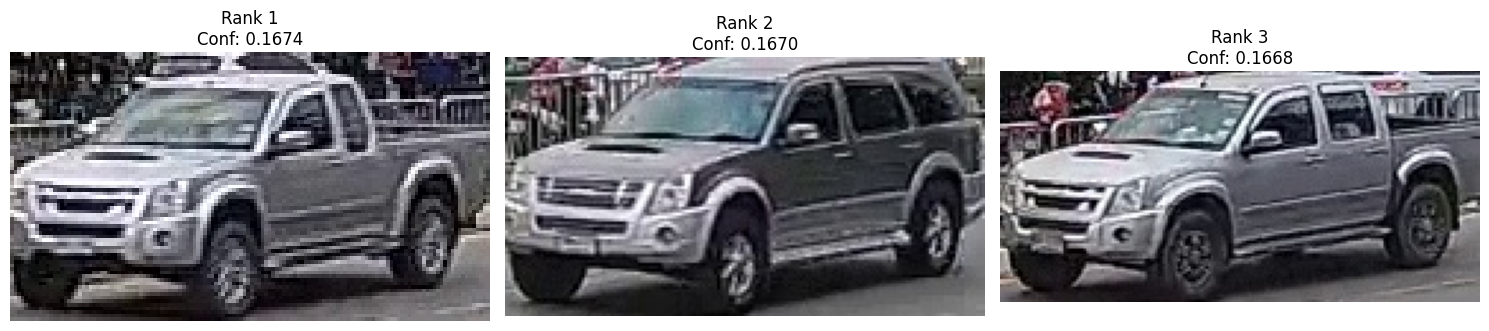

In [32]:
search_and_display("A isuzu", top_k=3)


--- Rank 1 ---
Confidence: 0.1434
Image Path: /kaggle/input/cctv-more/DatasetCCTV(1)/set10/057.jpg
Groundtruth: {"car_type": "bus", "car_brand": "unknown", "car_model": "unknown", "primary_color": "blue", "secondary_color": "black", "wheel_color": "black", "other_car_marks": "none", "num_of_drivers": 1, "driver_shirt_color": ["white"], "other_driver_marks": "none"}
Query: 'A bus'
Rank 1: /kaggle/input/cctv-more/DatasetCCTV(1)/set10/057.jpg (Confidence: 0.1434)
Rank 2: /kaggle/input/cctv-more/DatasetCCTV(1)/set6/066.jpg (Confidence: 0.1406)
Rank 3: /kaggle/input/cctv-more/DatasetCCTV(1)/set6/004.jpg (Confidence: 0.1394)


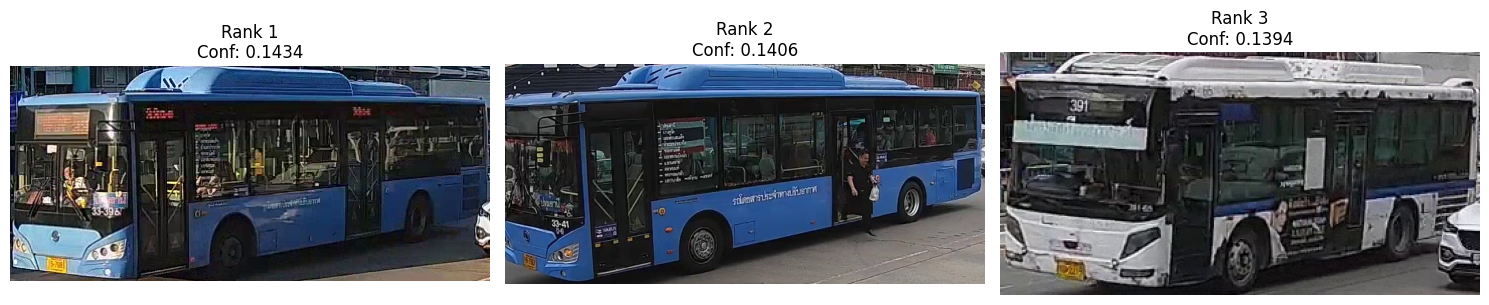

In [33]:
search_and_display("A bus", top_k=3)


--- Rank 1 ---
Confidence: 0.1506
Image Path: /kaggle/input/cctv-more/DatasetCCTV(1)/set5/087.jpg
Groundtruth: {"car_type": "sedan", "car_brand": "Toyota", "car_model": "Corolla", "primary_color": "silver", "secondary_color": "", "wheel_color": "silver", "other_car_marks": "", "num_of_drivers": 1, "driver_shirt_color": ["black"], "other_driver_marks": ""}
Query: 'A corolla altis'
Rank 1: /kaggle/input/cctv-more/DatasetCCTV(1)/set5/087.jpg (Confidence: 0.1506)
Rank 2: /kaggle/input/cctv-more/DatasetCCTV(1)/set5/086.jpg (Confidence: 0.1503)
Rank 3: /kaggle/input/cctv-more/DatasetCCTV(2-3)/DatasetCCTV(2-3)/set3/029.jpg (Confidence: 0.1499)


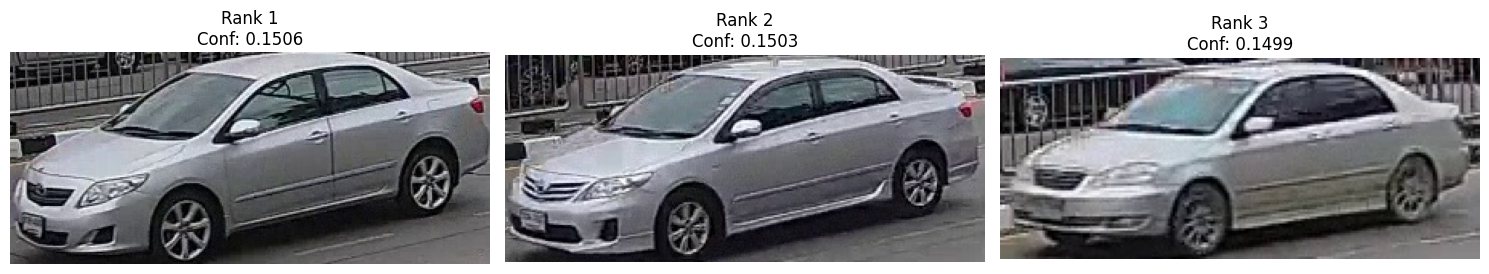

In [34]:
search_and_display("A corolla altis", top_k=3)


--- Rank 1 ---
Confidence: 0.1475
Image Path: /kaggle/input/cctv-more/DatasetCCTV(2-3)/DatasetCCTV(2-3)/set3/066.jpg
Groundtruth: {"car_type": "sedan", "car_brand": "BMW", "car_model": "3 Series", "primary_color": "silver", "secondary_color": "", "wheel_color": "black", "other_car_marks": "", "num_of_drivers": 1, "driver_shirt_color": [], "other_driver_marks": ""}
Query: 'A BMW'
Rank 1: /kaggle/input/cctv-more/DatasetCCTV(2-3)/DatasetCCTV(2-3)/set3/066.jpg (Confidence: 0.1475)
Rank 2: /kaggle/input/cctv-more/DatasetCCTV(1)/set6/014.jpg (Confidence: 0.1427)
Rank 3: /kaggle/input/cctv-more/DatasetCCTV(1)/set7/031.jpg (Confidence: 0.1372)


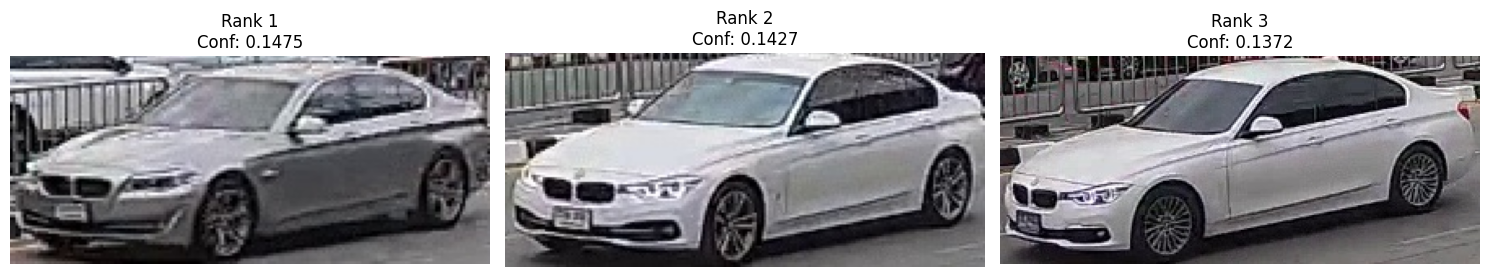

In [35]:
search_and_display("A BMW", top_k=3)


--- Rank 1 ---
Confidence: 0.1782
Image Path: /kaggle/input/cctv-more/DatasetCCTV(1)/set8/027.jpg
Groundtruth: {"car_type": "sports car", "car_brand": "Honda", "car_model": "Civic", "primary_color": "red", "secondary_color": "", "wheel_color": "black", "other_car_marks": "", "num_of_drivers": 1, "driver_shirt_color": [], "other_driver_marks": ""}
Query: 'red honda'
Rank 1: /kaggle/input/cctv-more/DatasetCCTV(1)/set8/027.jpg (Confidence: 0.1782)
Rank 2: /kaggle/input/cctv-more/DatasetCCTV(2-3)/DatasetCCTV(2-3)/set2/035.jpg (Confidence: 0.1634)
Rank 3: /kaggle/input/cctv-more/DatasetCCTV(1)/set5/099.jpg (Confidence: 0.1626)


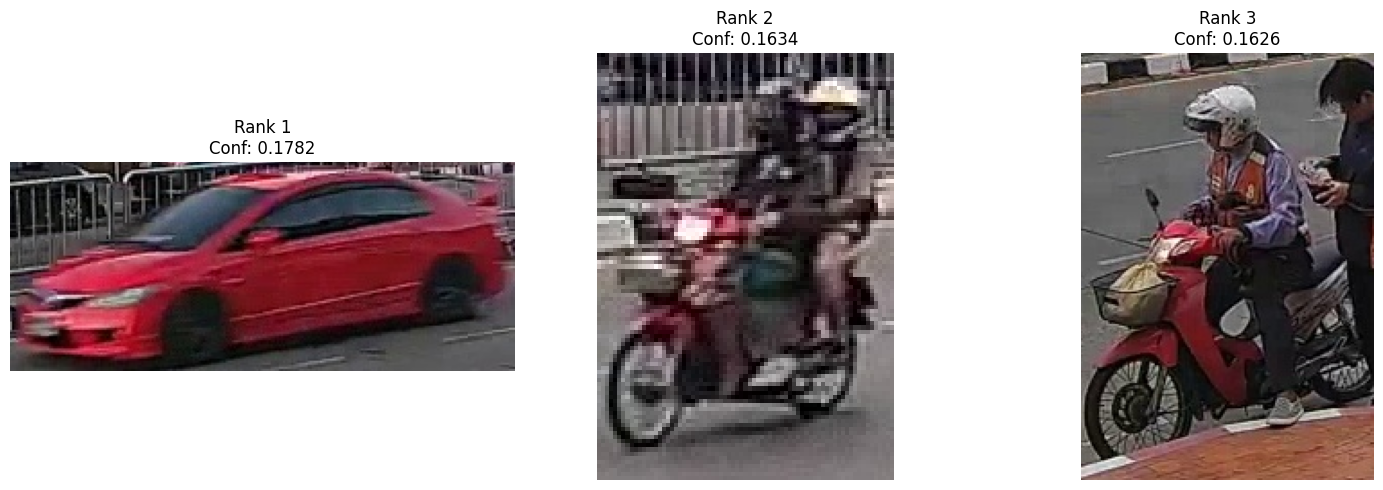

In [36]:
search_and_display("red honda", top_k=3)


--- Rank 1 ---
Confidence: 0.1518
Image Path: /kaggle/input/cctv-more/DatasetCCTV(2-3)/DatasetCCTV(2-3)/set3/084.jpg
Groundtruth: {"car_type": "van", "car_brand": "Toyota", "car_model": "Hiace", "primary_color": "white", "secondary_color": "blue", "wheel_color": "black", "other_car_marks": "roof rack, decals", "num_of_drivers": 1, "driver_shirt_color": ["white"], "other_driver_marks": "none"}
Query: 'songthaew'
Rank 1: /kaggle/input/cctv-more/DatasetCCTV(2-3)/DatasetCCTV(2-3)/set3/084.jpg (Confidence: 0.1518)
Rank 2: /kaggle/input/cctv-more/DatasetCCTV(1)/set5/018.jpg (Confidence: 0.1498)
Rank 3: /kaggle/input/cctv-more/DatasetCCTV(1)/set6/027.jpg (Confidence: 0.1449)


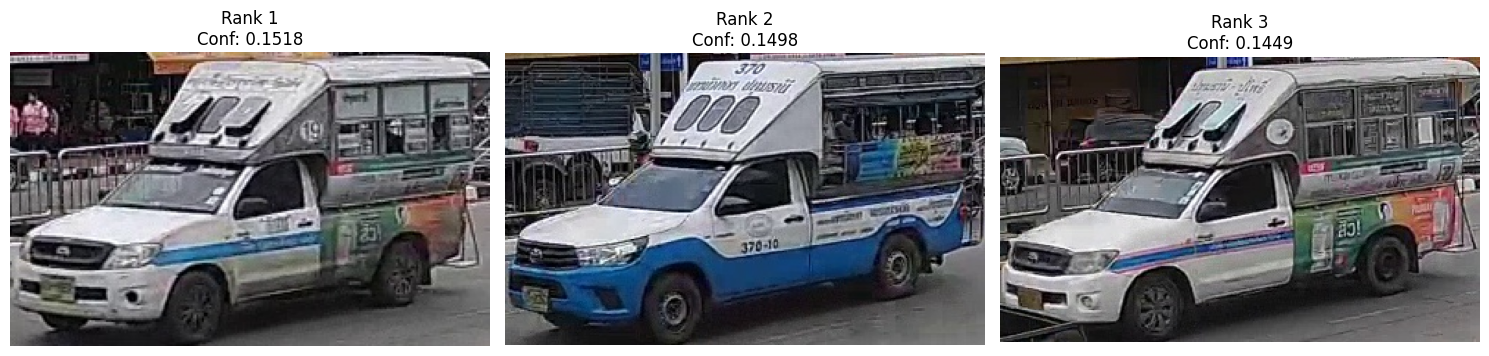

In [37]:
search_and_display("songthaew", top_k=3)


--- Rank 1 ---
Confidence: 0.1210
Image Path: /kaggle/input/cctv-more/DatasetCCTV(2-3)/DatasetCCTV(2-3)/set3/084.jpg
Groundtruth: {"car_type": "van", "car_brand": "Toyota", "car_model": "Hiace", "primary_color": "white", "secondary_color": "blue", "wheel_color": "black", "other_car_marks": "roof rack, decals", "num_of_drivers": 1, "driver_shirt_color": ["white"], "other_driver_marks": "none"}
Query: 'โตโยต้า'
Rank 1: /kaggle/input/cctv-more/DatasetCCTV(2-3)/DatasetCCTV(2-3)/set3/084.jpg (Confidence: 0.1210)
Rank 2: /kaggle/input/cctv-more/DatasetCCTV(1)/set7/077.jpg (Confidence: 0.1205)
Rank 3: /kaggle/input/cctv-more/DatasetCCTV(1)/set6/072.jpg (Confidence: 0.1181)


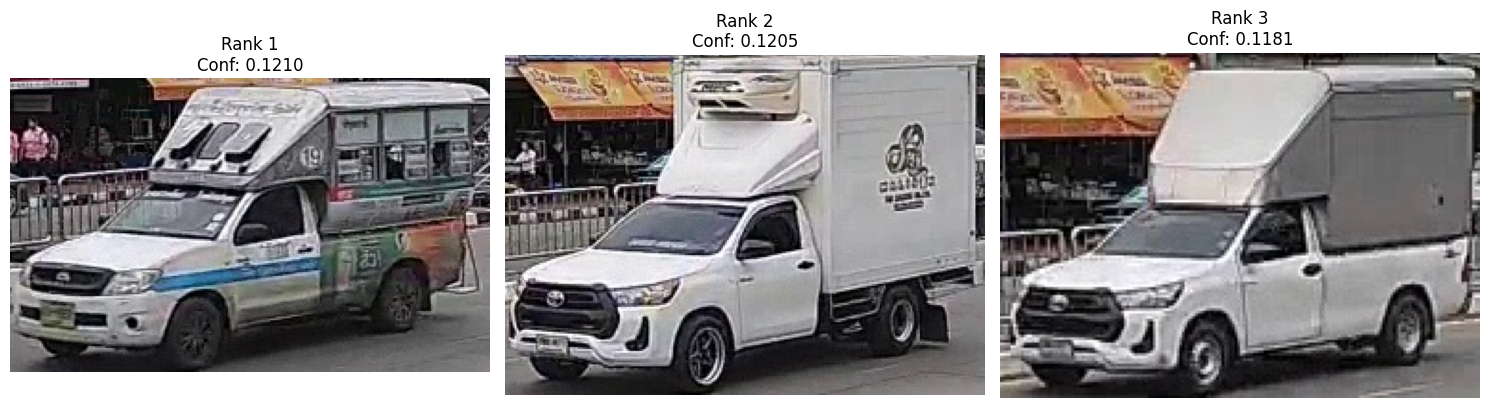

In [39]:
search_and_display("โตโยต้า", top_k=3)